# torchkeras.KerasModel tune hyperparameters Demo

You can install torchkeras using pip:
`pip install torchkeras`

Here is a mnist cnn example using torchkeras.KerasModel to auto tune the hyperparameters with help of wandb.sweep.


`pip install wandb`


Before you start run this demo, you should first create an account at wandb website  https://wandb.ai/ ,

and get your API keys from the settings page。

You can explore the wandb dashboard created in this demo from the url below:

https://wandb.ai/lyhue1991/mnist_torchkeras


In [ ]:
#!pip install wandb 

In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import wandb 
wandb.login() 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lyhue1991. Use `wandb login --relogin` to force relogin


True

In [3]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

import torchkeras #Attention this line 
print(torchkeras.__version__)

3.9.3


## 0, set hyperparameters 

In [4]:
from argparse import Namespace


config = Namespace(
    project_name = "mnist_torchkeras",
    
    batch_size = 512,
    
    hidden_layer_width = 64,
    dropout_p = 0.1,
    
    lr = 1e-4,
    optim_type = 'Adam',
    
    epochs = 10,
    ckpt_path = 'checkpoint'
)


## 1, prepare data 

In [5]:
import torchvision 
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="mnist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="mnist/",train=False,download=True,transform=transform)
    
def create_dataloaders(config):
    ds_train_sub = torch.utils.data.Subset(ds_train, indices=range(0, len(ds_train), 10))
    dl_train =  torch.utils.data.DataLoader(ds_train_sub, batch_size=config.batch_size, shuffle=True, num_workers=2)
    dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=config.batch_size, shuffle=False, num_workers=2)
    return dl_train,dl_val 

dl_train,dl_val = create_dataloaders(config)



In [6]:
for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)


torch.Size([512, 1, 28, 28])
torch.Size([512])


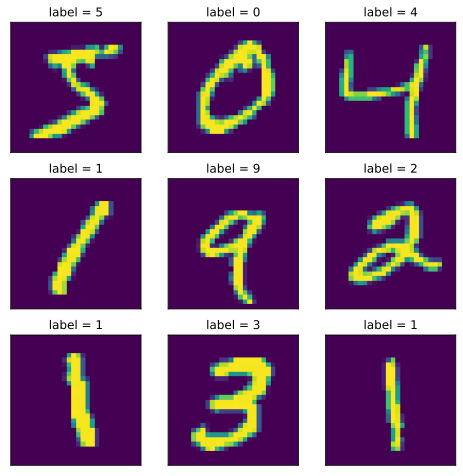

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#visual some samples
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()



## 2, create the  model

In [8]:
def create_net(config):
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=config.hidden_layer_width,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2)) 
    net.add_module("conv2",nn.Conv2d(in_channels=config.hidden_layer_width,
                                     out_channels=config.hidden_layer_width,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = config.dropout_p))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(config.hidden_layer_width,config.hidden_layer_width))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(config.hidden_layer_width,10))
    return net 

net = create_net(config)

class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        m = (preds == targets).sum()
        n = targets.shape[0] 
        self.correct += m 
        self.total += n
        
        return m/n

    def compute(self):
        return self.correct.float() / self.total 
    
    def reset(self):
        self.correct -= self.correct
        self.total -= self.total
        

In [9]:
def create_model(config):
    net = create_net(config)
    optim_type = torch.optim.__dict__[config.optim_type]
    model = torchkeras.KerasModel(net,
          loss_fn = nn.CrossEntropyLoss(),
          optimizer = optim_type(params=net.parameters(), lr=config.lr),
          metrics_dict = {"acc":Accuracy()}
        )
    return model

from torchkeras import summary
model = create_model(config)
summary(model,input_data=features);



--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                            [-1, 64, 26, 26]                  640
MaxPool2d-2                         [-1, 64, 13, 13]                    0
Conv2d-3                              [-1, 64, 9, 9]              102,464
MaxPool2d-4                           [-1, 64, 4, 4]                    0
Dropout2d-5                           [-1, 64, 4, 4]                    0
AdaptiveMaxPool2d-6                   [-1, 64, 1, 1]                    0
Flatten-7                                   [-1, 64]                    0
Linear-8                                    [-1, 64]                4,160
ReLU-9                                      [-1, 64]                    0
Linear-10                                   [-1, 10]                  650
Total params: 107,914
Trainable params: 107,914
Non-trainable params: 0
---------------------------------------

## 3, train the model

we start train the model once using the default hyperparameters to ensure everything is right.


<<<<<< 🚀 mps is used >>>>>>


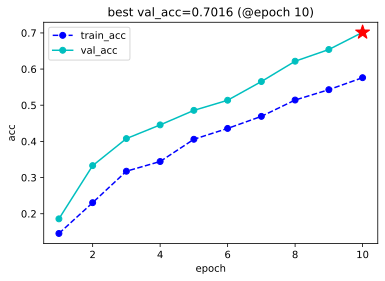

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


best_val_acc,▁▃▄▅▅▅▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▄▄▅▆▆▇▇█
train_loss,██▇▆▆▅▄▃▂▁
val_acc,▁▃▄▅▅▅▆▇▇█
val_loss,██▇▆▆▅▄▃▂▁
best_score,0.7016
best_val_acc,0.7016
epoch,10.0
lr,0.0001


In [10]:
from torchkeras.kerascallbacks import WandbCallback

wandb_cb = WandbCallback(project=config.project_name,
                         config=config,
                         name=None,
                         save_code=True,
                         save_ckpt=True)

dfhistory=model.fit(train_data=dl_train, 
                    val_data=dl_val, 
                    epochs=config.epochs, 
                    patience=3, 
                    monitor="val_acc",
                    mode="max",
                    ckpt_path='checkpoint.pt',
                    callbacks = [wandb_cb]
                   )


## 4, tune hyperparameters 


In [15]:
from argparse import Namespace

config = Namespace(
    project_name = 'mnist_torchkeras',
    
    batch_size = 512,
    
    hidden_layer_width = 64,
    dropout_p = 0.1,
    
    lr = 1e-4,
    optim_type = 'Adam',
    
    epochs = 10,
    ckpt_path = 'checkpoint.pt'
)


In [16]:
#1，search method
sweep_config = {'method': 'random'} # one of ['grid','random','bayes']

#2，search target
sweep_config['metric'] =  {'name': 'val_acc', 'goal': 'maximize'}

#3，hyperparameters space
sweep_config['parameters'] = {}

#fixed hyperparameters
sweep_config['parameters'].update({
    'project_name':{'value':config.project_name},
    'epochs': {'value': 10},
    'ckpt_path': {'value':'checkpoint.pt'}})

#discrete hyperparameters
sweep_config['parameters'].update({
    'optim_type': {
        'values': ['Adam', 'SGD','AdamW']
        },
    'hidden_layer_width': {
        'values': [16,32,48,64,80,96,112,128]
        }
    })

#continuous hyperparameters
sweep_config['parameters'].update({
    
    'lr': {
        'distribution': 'log_uniform_values',
        'min': 1e-6,
        'max': 0.1
      },
    
    'batch_size': {
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 32,
        'max': 256,
      },
    
    'dropout_p': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.6,
      }
})



#4, prune strategy

#decide prune or not at epoch 3,6,12
sweep_config['early_terminate'] = {'type':'hyperband','min_iter':3, 'eta': 2, 's':3} 

from pprint import pprint 
pprint(sweep_config)




{'early_terminate': {'eta': 2, 'min_iter': 3, 's': 3, 'type': 'hyperband'},
 'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_acc'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 256,
                               'min': 32,
                               'q': 8},
                'ckpt_path': {'value': 'checkpoint.pt'},
                'dropout_p': {'distribution': 'uniform', 'max': 0.6, 'min': 0},
                'epochs': {'value': 10},
                'hidden_layer_width': {'values': [16,
                                                  32,
                                                  48,
                                                  64,
                                                  80,
                                                  96,
                                                  112,
                                                  128]},
                'lr': {'distribution': 'l

In [17]:
sweep_id = wandb.sweep(sweep_config, project='mnist_torchkeras')


Create sweep with ID: ad8y5buz
Sweep URL: https://wandb.ai/lyhue1991/mnist_torchkeras/sweeps/ad8y5buz


In [18]:
from torchkeras.kerascallbacks import WandbCallback
def train(config=None):
    
    wandb_cb = WandbCallback(project='mnist_torchkeras',
                            config=config,
                            save_code=True)
    
    with wandb.init(project = wandb_cb.project,
                    config = wandb_cb.config,
                    name = wandb_cb.name):
        
        config = wandb.config
        
        #1，prepare datasets
        dl_train, dl_val =  create_dataloaders(config)
        
        #2，prepare model
        model = create_model(config)
        
        #2，fit the model
        dfhistory = model.fit(
            train_data = dl_train,
            val_data=dl_val,
            epochs=config.epochs,
            ckpt_path=config.ckpt_path,
            patience=3,
            monitor='val_acc',
            mode='max',
            mixed_precision='no',
            callbacks= [wandb_cb]) 
        return model
    

wandb: Agent Starting Run: r9w1exdd with config:
wandb: 	batch_size: 40
wandb: 	ckpt_path: checkpoint.pt
wandb: 	dropout_p: 0.32243880949259884
wandb: 	epochs: 10
wandb: 	hidden_layer_width: 32
wandb: 	lr: 0.0902581402613245
wandb: 	optim_type: SGD
wandb: 	project_name: mnist_torchkeras
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


<<<<<< 🚀 mps is used >>>>>>


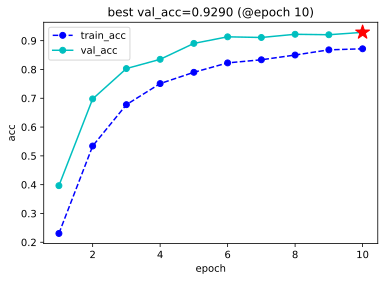

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


best_val_acc,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
train_acc,▁▄▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
best_score,0.929
best_val_acc,0.929
epoch,10.0
lr,0.09026


wandb: Agent Starting Run: irjh3ia1 with config:
wandb: 	batch_size: 200
wandb: 	ckpt_path: checkpoint.pt
wandb: 	dropout_p: 0.02054526420344269
wandb: 	epochs: 10
wandb: 	hidden_layer_width: 112
wandb: 	lr: 4.863703847305973e-05
wandb: 	optim_type: SGD
wandb: 	project_name: mnist_torchkeras
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


<<<<<< 🚀 mps is used >>>>>>


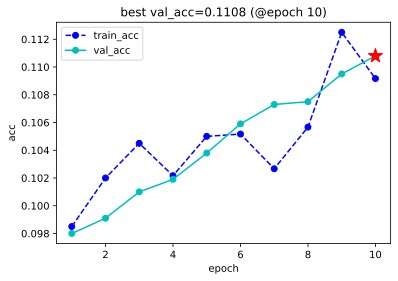

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


best_val_acc,▁▂▃▃▄▅▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▄▃▄▄▃▅█▆
train_loss,█▇▆▆▆▄▄▂▃▁
val_acc,▁▂▃▃▄▅▆▆▇█
val_loss,█▇▆▆▅▄▃▃▂▁
best_score,0.1108
best_val_acc,0.1108
epoch,10.0
lr,5e-05


wandb: Agent Starting Run: lyuf94na with config:
wandb: 	batch_size: 56
wandb: 	ckpt_path: checkpoint.pt
wandb: 	dropout_p: 0.34505381197043267
wandb: 	epochs: 10
wandb: 	hidden_layer_width: 32
wandb: 	lr: 1.287749909658862e-05
wandb: 	optim_type: AdamW
wandb: 	project_name: mnist_torchkeras
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


<<<<<< 🚀 mps is used >>>>>>


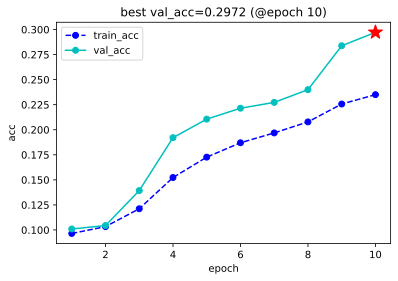

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


best_val_acc,▁▁▂▄▅▅▆▆██
epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▂▄▅▆▆▇██
train_loss,█▇▆▆▅▄▃▃▂▁
val_acc,▁▁▂▄▅▅▆▆██
val_loss,█▇▆▅▅▄▃▃▂▁
best_score,0.2972
best_val_acc,0.2972
epoch,10.0
lr,1e-05


In [19]:
# try 3 times
wandb.agent(sweep_id, train, count=3)

## 5, load the best checkpoint 


In [20]:
import pandas as pd 
import wandb
api = wandb.Api()
    
entity, project = "lyhue1991", "mnist_torchkeras"  # set to your entity and project 

def get_best_run_id(entity,project,metric_mode='max'):
    runs = api.runs(entity + "/" + project) 
    data = []
    for run in runs:
        run_info = {'run_id':run.id,'run_name':run.name,'best_score':run.summary['best_score']}
        data.append(run_info)
    dfruns = pd.DataFrame(data) 
    dfruns.sort_values(by = 'best_score', 
                   ascending= False if metric_mode=='max' else True,
                   inplace = True)
    best_run_id = dfruns['run_id'].iloc[0]
    return best_run_id 

def get_model_versions(entity,project):
    model_versions = api.artifact_versions('model',
        name = entity + "/" + project+'/' + 'checkpoint')
    return [x.version for x in model_versions]


In [21]:
best_run_id = get_best_run_id(entity,project)
print(best_run_id)

2a61qmcd


In [22]:
model_versions = get_model_versions(entity,project)
print(model_versions)

['v49', 'v48', 'v47', 'v46', 'v45', 'v44', 'v43', 'v42', 'v41', 'v40', 'v39', 'v38', 'v37', 'v36', 'v35', 'v34', 'v33', 'v32', 'v31', 'v30', 'v29', 'v28', 'v27', 'v26', 'v20', 'v14', 'v13', 'v9', 'v3', 'v2', 'v1', 'v0']


In [23]:
best_run = api.run(path= entity + "/" + project+'/'+ best_run_id)

In [24]:
best_model_arti = None
for arti in best_run.logged_artifacts():
    if arti.type=='model':
        best_model_arti = arti

print(best_model_arti.version) 

best_model_arti.download(root='best_ckpt')

v2


wandb:   1 of 1 files downloaded.  


'best_ckpt'